In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm_notebook
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
print(df.groupby('label').size())

label
ham     4825
spam     747
dtype: int64


In [4]:
le = preprocessing.LabelEncoder()
le.fit(df['label'])
target = le.transform(df['label'])

df['encoding'] = target
labels = np.array(df['encoding'])

df

,label,text,encoding
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [5]:
tokenizer = TreebankWordTokenizer()

token_list = []

for text in df['text']:
    text_tokens = tokenizer.tokenize(text.lower())
    text_tokens = [w for w in text_tokens if re.findall(r'^[a-z0-9_]*$', w)] # alphanumeric words
    token_list.append(text_tokens)
    
df['tokenized_text'] = token_list
df

,label,text,encoding,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[go, until, jurong, point, available, only, in..."
1,ham,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, i, do, think, he, goes, to, usf, he, liv..."
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,"[will, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",0,"[pity, was, in, mood, for, so, any, other, sug..."
5570,ham,The guy did some bitching but I acted like i'd...,0,"[the, guy, did, some, bitching, but, i, acted,..."


In [6]:
print("Original text:", df['text'][70])
print("Tokenized text:", df['tokenized_text'][70])

Original text: Wah lucky man... Then can save money... Hee...
Tokenized text: ['wah', 'lucky', 'man', 'then', 'can', 'save', 'money', 'hee']


In [7]:
df = df[df['tokenized_text'].map(lambda d: len(d)) > 1]
df

,label,text,encoding,tokenized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[go, until, jurong, point, available, only, in..."
1,ham,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, i, do, think, he, goes, to, usf, he, liv..."
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,"[will, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",0,"[pity, was, in, mood, for, so, any, other, sug..."
5570,ham,The guy did some bitching but I acted like i'd...,0,"[the, guy, did, some, bitching, but, i, acted,..."


In [8]:
print(df['label'].value_counts())

ham     4774
spam     746
Name: label, dtype: int64


In [9]:
from gensim.models.word2vec import Word2Vec
num_features = 200 # length of word vector 
min_word_count = 5 # minimum number of word count to be considered in the model
window_size = 10 # context window size (length of n-grams)
num_workers = 20 # CPU threads to be used in training
subsampling = 0.001 # samping rate for frequent terms
skip_gram_or_cbow  = 1 # CBOW(0) or skip gram(1), default cbow
model = Word2Vec(df['tokenized_text'],workers=num_workers,vector_size=num_features, min_count= min_word_count,window=window_size,sample=subsampling,sg = skip_gram_or_cbow)
model_name = 'custom_embed'
model.save(model_name)
model_name= "custom_embed"
trained_model = Word2Vec.load(model_name)

In [10]:
print("vocabulary size",len(trained_model.wv.index_to_key))
trained_model.wv.index_to_key

vocabulary size 1680


['i',
 'to',
 'you',
 'a',
 'the',
 'u',
 'and',
 'is',
 'in',
 'my',
 'me',
 'for',
 'your',
 'it',
 'of',
 'have',
 'call',
 'that',
 'on',
 'do',
 'are',
 '2',
 'so',
 'not',
 'but',
 'now',
 'or',
 'can',
 'at',
 'we',
 'get',
 'ur',
 'if',
 'with',
 'be',
 'will',
 'just',
 'this',
 'gt',
 'lt',
 'no',
 'how',
 'when',
 'up',
 'from',
 'what',
 'go',
 'all',
 'free',
 '4',
 'know',
 'out',
 'got',
 'was',
 'like',
 'then',
 'come',
 'ok',
 'good',
 'am',
 'he',
 'there',
 'its',
 'only',
 'time',
 'send',
 'want',
 'text',
 'as',
 'love',
 'going',
 'by',
 'txt',
 'one',
 'day',
 'about',
 'did',
 'need',
 'still',
 'r',
 'she',
 'see',
 'sorry',
 'n',
 'back',
 'our',
 'reply',
 'dont',
 'mobile',
 'home',
 'new',
 'tell',
 'stop',
 'any',
 'they',
 'think',
 'take',
 'been',
 'today',
 'later',
 'please',
 'hi',
 'has',
 'some',
 'da',
 'phone',
 'who',
 'her',
 'an',
 'pls',
 'lor',
 'where',
 'claim',
 'c',
 'hope',
 'more',
 'much',
 'him',
 'here',
 'night',
 'na',
 'well',


In [11]:
trained_model.wv["love"]

array([-0.08290443, -0.20163846, -0.03666939,  0.11856652,  0.13035586,
        0.10561588,  0.07450773,  0.0614638 , -0.07864849,  0.1288343 ,
       -0.08120969,  0.10307258,  0.28536722,  0.13946138, -0.10522238,
       -0.06279279,  0.1278311 ,  0.12168659,  0.21418951, -0.06442962,
        0.18445113, -0.17114612,  0.01435574,  0.07426473,  0.2033843 ,
       -0.05029422,  0.02051232,  0.05318072,  0.09840935, -0.03784297,
        0.1372698 ,  0.10946072,  0.07903682, -0.0179239 ,  0.00440134,
        0.08902397,  0.03633291, -0.06200819, -0.00314284, -0.08669871,
       -0.23130064,  0.04664201, -0.15497237,  0.05096914,  0.01140858,
       -0.09380918, -0.16191506, -0.03860095,  0.0193979 , -0.03311829,
       -0.00886287,  0.11478319,  0.09893987,  0.05360267,  0.00339513,
       -0.04769761, -0.181442  , -0.11745057, -0.03763317,  0.18384728,
       -0.02004334, -0.09313896,  0.15650074,  0.01248309, -0.34376332,
        0.04170158,  0.04059789,  0.08043935, -0.01352246,  0.09

In [12]:
trained_model.wv.most_similar("love", topn = 5)

[('miss', 0.9331154227256775),
 ('life', 0.8866835236549377),
 ('how', 0.8813088536262512),
 ('sweet', 0.8808433413505554),
 ('babe', 0.8795915246009827)]

In [13]:
def get_embedding_trained_w2v(w2v_model,doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(200)
    else:
        for tok in doc_tokens:
            if tok in w2v_model.wv.index_to_key:
                embeddings.append(w2v_model.wv[tok])
            else: 
                embeddings.append(np.random.rand(200))
        #mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

In [14]:
doc_vectors = []
for tokenized_tweets in tqdm_notebook(df['tokenized_text']):
    doc_vectors.append(get_embedding_trained_w2v(trained_model,tokenized_tweets))
df['doc_vectors'] = doc_vectors
df

  0%|          | 0/5520 [00:00<?, ?it/s]

,label,text,encoding,tokenized_text,doc_vectors
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[go, until, jurong, point, available, only, in...","[0.03004691128433442, -0.014944161340463433, 0..."
1,ham,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]","[0.01749656303570929, -0.0862287151273064, 0.0..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[0.15453182902597967, 0.04098200010506296, 0.0..."
3,ham,U dun say so early hor... U c already then say...,0,"[u, dun, say, so, early, hor, u, c, already, t...","[0.05887123776281589, -0.19188406678895611, 0...."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, i, do, think, he, goes, to, usf, he, liv...","[-0.06323908274178801, -0.03230191947879692, 0..."
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,"[this, is, the, 2nd, time, we, have, tried, 2,...","[-0.00918587563569262, 0.0479341417232115, 0.0..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,"[will, b, going, to, esplanade, fr, home]","[0.024667906448421602, -0.053713129401177784, ..."
5569,ham,"Pity, * was in mood for that. So...any other s...",0,"[pity, was, in, mood, for, so, any, other, sug...","[0.10190880752704679, 0.16744644591602667, 0.1..."
5570,ham,The guy did some bitching but I acted like i'd...,0,"[the, guy, did, some, bitching, but, i, acted,...","[-0.037588390026599534, -0.006007940854170202,..."


In [15]:
print("Original text:", df['text'][70])
print("Tokenized text:", df['tokenized_text'][70])

Original text: Wah lucky man... Then can save money... Hee...
Tokenized text: ['wah', 'lucky', 'man', 'then', 'can', 'save', 'money', 'hee']


In [16]:
print("Document Vector:", df['doc_vectors'][70])

Document Vector: [ 0.02238492  0.03711066  0.04575791  0.11228139  0.14709481 -0.01764129
  0.08215092  0.19029598  0.05874979  0.17791781  0.07349009 -0.01806394
  0.01756683  0.22908718  0.10158037  0.02148466 -0.05238575  0.11196341
  0.10487489 -0.10212642  0.24643735 -0.0917663  -0.07382656  0.0421581
  0.03970637 -0.00866944  0.10538066 -0.00941962 -0.08902002  0.23172648
  0.17648753  0.19008218  0.00750861  0.00956379  0.07596288  0.05841934
  0.01512399  0.0220227   0.00055938  0.00566404 -0.00999923  0.03920956
 -0.07355844  0.09302753  0.23647739 -0.04472218  0.07548781  0.02018455
  0.13178261  0.13250005  0.09437091  0.00267145  0.13204508 -0.00585665
  0.13073043 -0.02077834  0.11866824 -0.11053113  0.00497535  0.0980695
  0.11500291  0.11116122  0.02988763 -0.01239616 -0.07084724  0.06650503
  0.07333292  0.18258242 -0.01868886  0.15881296  0.09562873  0.12035889
  0.14491079 -0.00465374  0.18827404  0.23742321  0.17871067  0.01784582
 -0.04313091 -0.04870233 -0.07604152

In [17]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, df['encoding'], test_size=0.2, random_state = 42)

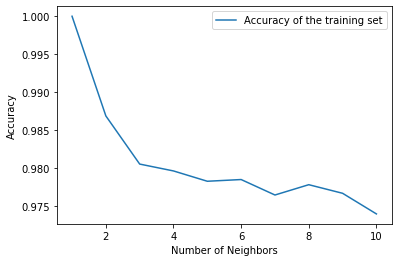

In [18]:
training_accuracy = []
test_accuracy = []

#try KNN for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,11)

for n_neighbors in neighbors_setting:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train,y_train)
    training_accuracy.append(knn.score(X_train, y_train))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend();

In [19]:
print("Accuracy of the training set for 10NN: {:3f}".format(training_accuracy[4]))

Accuracy of the training set for 10NN: 0.978261


In [20]:
knn_grid = KNeighborsClassifier()

grid_params = {
    "n_neighbors": range(1, 21, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']    
}

gs_knn = GridSearchCV(knn_grid,
                     param_grid = grid_params,
                     cv = 5,
                     verbose = 0,
                     scoring = 'accuracy',
                     n_jobs = -1)

grid_model = gs_knn.fit(X_train, y_train)

In [21]:
knn_pred = grid_model.predict(X_test)

grid_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

KNN Report
Accuracy: 0.9728260869565217
F1 score: 0.9729112111944239
Recall: 0.9728260869565217
Precision: 0.9730098718756565

 K Neighbors Classifier report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       968
           1       0.88      0.90      0.89       136

    accuracy                           0.97      1104
   macro avg       0.93      0.94      0.94      1104
weighted avg       0.97      0.97      0.97      1104



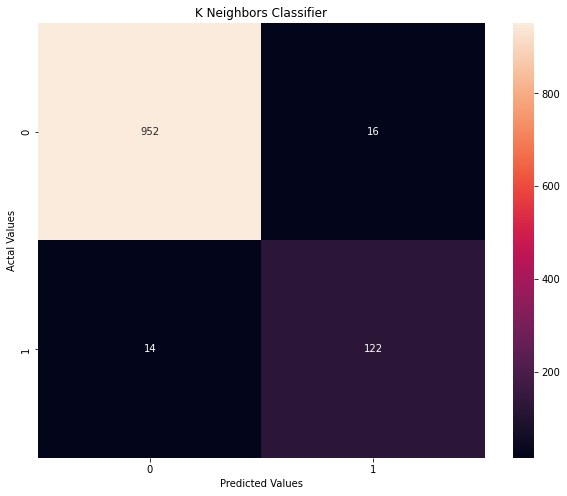

In [22]:
print('KNN Report')
print ('Accuracy:', accuracy_score(y_test, knn_pred))
print ('F1 score:', f1_score(y_test, knn_pred,average='weighted'))
print ('Recall:', recall_score(y_test, knn_pred,
                              average='weighted'))
print ('Precision:', precision_score(y_test, knn_pred,
                                    average='weighted'))
print ('\n K Neighbors Classifier report:\n', classification_report(y_test, knn_pred))

cm = confusion_matrix(y_test, knn_pred)
cm_df = pd.DataFrame(cm, index = ['0', '1',],
                     columns=['0', '1'])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt = 'g')
plt.title('K Neighbors Classifier')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()